# Reinforcement Learning Project

## Task 1

### **1a. Environment Setup**


In [48]:
import numpy as np
import random

class TrafficEnvironment:
    def __init__(self, lanes=5, initial_distance_range=(3000, 4000)):
        """
        Args:
        - lanes (int): Number of lanes (default is 5).
        - initial_distance_range (tuple): Range for randomly initializing the distance from destination.
        """
        self.lanes = lanes
        self.initial_distance_range = initial_distance_range
        self.state = None
        self.rounding_precision = 1
        self.clearance_rate_min = 0
        # self.reset()

    def reset(self):
        # Initialize the state: distance from destination, current lane, and clearance rates for each lane
        # Initialize distance from destination to a random value within the provided range
        self.distance = round(random.uniform(*self.initial_distance_range), self.rounding_precision)
        self.current_lane = random.randint(1, self.lanes)  # Random lane from 1 to 5
        # Initialize clearance rates randomly between 15 and 20 for all lanes
        self.clearance_rates = np.round(np.random.uniform(15, 20, size=self.lanes), self.rounding_precision)

        print('Initial Distance: ', self.distance)
        print('Initial Clearance Rates: ', self.clearance_rates)
        print('Initial Lane: ', self.current_lane)

        # Subtract the clearance rate of the current lane from the distance for the first state
        # self.distance -= self.clearance_rates[self.current_lane - 1]
        # self.distance = round(self.distance, self.rounding_precision)

        # Create an empty list to store state history (3 past states)
        self.state_history = [(self.distance, self.current_lane, *self.clearance_rates)]
        self.time_step = 0

        # Return the initial state
        return self.get_state()

    def get_state(self):
        # Return the most recent 3 states, if available, otherwise repeat initial state
        history_length = len(self.state_history)
        if history_length < 3:
            padding = [self.state_history[0]] * (3 - history_length)
            return padding + self.state_history
        else:
            return self.state_history[-3:]

    def step(self, action):
        """
        Takes an action (-1: move left, 0: stay, 1: move right), updates the state and returns:
        - Next state
        - Reward
        - Done (whether the episode is over)
        """
        reward = 0
        done = False

        # Handle lane change
        if action == -1:
            if self.current_lane > 1:
                # Move left if not in the leftmost lane
                reward += self.attempt_lane_change(-1)
            else:
                # If in the leftmost lane, can't move left, but still penalize for the attempt
                reward -= 5  # Penalty for attempting invalid move

        elif action == 1:
            if self.current_lane < self.lanes:
                # Move right if not in the rightmost lane
                reward += self.attempt_lane_change(1)
            else:
                # If in the rightmost lane, can't move right, but still penalize for the attempt
                reward -= 5  # Penalty for attempting invalid move

        # Update lane clearance rates based on neighboring lanes
        self.update_clearance_rates()

        # Compute the distance covered in the current lane
        clearance_rate = self.clearance_rates[self.current_lane - 1]
        distance_covered = clearance_rate
        self.distance -= round(distance_covered, self.rounding_precision)
        self.distance = round(self.distance, self.rounding_precision)  # Round to match precision

        # Time penalty
        reward += distance_covered - 10
        reward = round(reward, self.rounding_precision)

        # Now, after all the updates for the current time step, append the state to history
        self.state_history.append((self.distance, self.current_lane, *self.clearance_rates))

        # Check if the episode is done (if the destination is reached)
        if self.distance <= 0:
            done = True
            self.distance = 0

        # Return the new state (after applying the current time step's updates), reward, and done flag
        return self.get_state(), reward, done

    def attempt_lane_change(self, direction):
        """
        Attempts to change lane.
        Direction: -1 for left, 1 for right.
        Returns the lane change reward.
        """
        if random.random() < 0.5:
            # Lane change succeeds
            self.current_lane += direction
            return -5  # Penalty for attempting a lane change
        else:
            # Lane change fails
            return -5  # Penalty even if the lane change fails

    def update_clearance_rates(self):
        # Update clearance rates based on adjacent lanes' speeds and add uncertainty term N(0, 0.1)
        updated_rates = self.clearance_rates.copy()
        for i in range(self.lanes):
            # Adding the uncertainty term N(0, 0.1)
            uncertainty = np.random.normal(0, 0.1)

            # Random Event: 5% chance of slowdown (20%-50%) and 5% chance of speedup (20%-40%)
            # 5% chance of slowdown
            if random.random() < 0.05:
                updated_rates[i] -= self.clearance_rates[i] * random.uniform(0.2, 0.5)

            # 5% chance of speedup
            if random.random() < 0.05:
                updated_rates[i] += self.clearance_rates[i] * random.uniform(0.2, 0.4)

            # Update based on adjacent lanes, with sgn function and uncertainty
            if i > 0:
                updated_rates[i] += 0.2 * np.sign(self.clearance_rates[i - 1] - self.clearance_rates[i])
            if i < self.lanes - 1:
                updated_rates[i] += 0.2 * np.sign(self.clearance_rates[i + 1] - self.clearance_rates[i])

            # Apply the uncertainty term to each lane
            updated_rates[i] += uncertainty

            # Round clearance rates to 4 significant digits
            updated_rates[i] = round(updated_rates[i], self.rounding_precision)

            # Ensure clearance rates don't drop below a minimum threshold
            updated_rates[i] = max(updated_rates[i], self.clearance_rate_min)

        self.clearance_rates = updated_rates

In [49]:
import matplotlib.pyplot as plt

# Example usage:
env = TrafficEnvironment()
state = env.reset()
done = False
rewards = []  # To track rewards at each time step
time_steps = []  # To track the time step number

time_step_counter = 0

while not done:
    # Randomly choose an action (-1: move left, 0: stay, 1: move right)
    action = random.choice([-1, 0, 1])

    # Take the step
    next_state, reward, done = env.step(action)

    # Append the reward for this time step
    rewards.append(reward)
    time_steps.append(time_step_counter)

    # Increment the time step counter
    time_step_counter += 1

    print(f"Action: {action}, Reward: {reward}, Done: {done}")
    print(f"Next State: {next_state}")

Initial Distance:  3959.3
Initial Clearance Rates:  [19.9 15.7 16.2 15.9 17.5]
Initial Lane:  5
Action: 1, Reward: 2.1, Done: False
Next State: [(3959.3, 5, 19.9, 15.7, 16.2, 15.9, 17.5), (3959.3, 5, 19.9, 15.7, 16.2, 15.9, 17.5), (3942.2, 5, 19.8, 16.1, 15.7, 22.2, 17.1)]
Action: -1, Reward: 6.6, Done: False
Next State: [(3959.3, 5, 19.9, 15.7, 16.2, 15.9, 17.5), (3942.2, 5, 19.8, 16.1, 15.7, 22.2, 17.1), (3920.6, 4, 19.5, 16.2, 16.0, 21.6, 17.1)]
Action: -1, Reward: 1.4, Done: False
Next State: [(3942.2, 5, 19.8, 16.1, 15.7, 22.2, 17.1), (3920.6, 4, 19.5, 16.2, 16.0, 21.6, 17.1), (3904.2, 3, 19.5, 16.1, 16.4, 21.0, 17.3)]
Action: 1, Reward: 1.3, Done: False
Next State: [(3920.6, 4, 19.5, 16.2, 16.0, 21.6, 17.1), (3904.2, 3, 19.5, 16.1, 16.4, 21.0, 17.3), (3887.9, 3, 19.2, 16.5, 16.3, 20.7, 17.3)]
Action: -1, Reward: 1.6, Done: False
Next State: [(3904.2, 3, 19.5, 16.1, 16.4, 21.0, 17.3), (3887.9, 3, 19.2, 16.5, 16.3, 20.7, 17.3), (3871.3, 3, 18.9, 16.5, 16.6, 20.3, 17.6)]
Action: 1, 

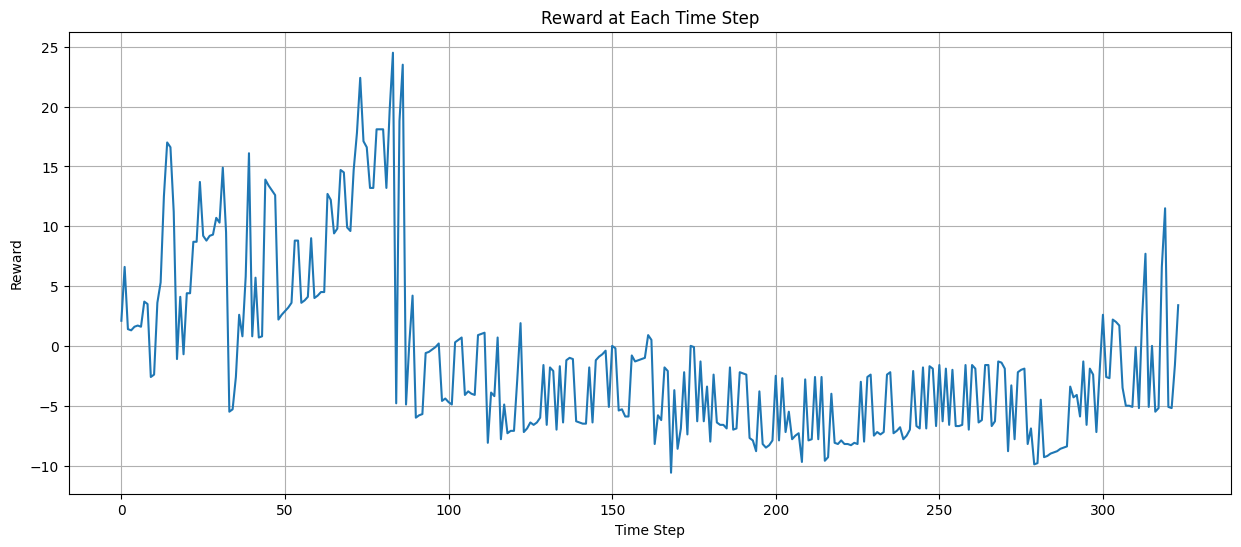

In [50]:
# Plot the rewards over time
plt.figure(figsize=(15, 6))
plt.plot(time_steps, rewards)
plt.title('Reward at Each Time Step')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.grid(True)
plt.show()